# Setup

In [2]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png"))
options(jupyter.plot_scale = 1.5)
require("pacman")
options(warn = -1)
pacman::p_load(tidyverse, lubridate, zoo, ggpubr, ggfortify, forecast, aod, tseries)

source('../Scripts/ReadData.R')
source('../Scripts/ModelSelection.R')
source('../Scripts/ResidualAnalysis.R')
source('../Scripts/Forecasting.R')

# Exploration and Cleaning

,Date,Quarter,Value
,<date>,<fct>,<dbl>
162,2020-04-01,Q2,68.1
163,2020-07-01,Q3,67.4


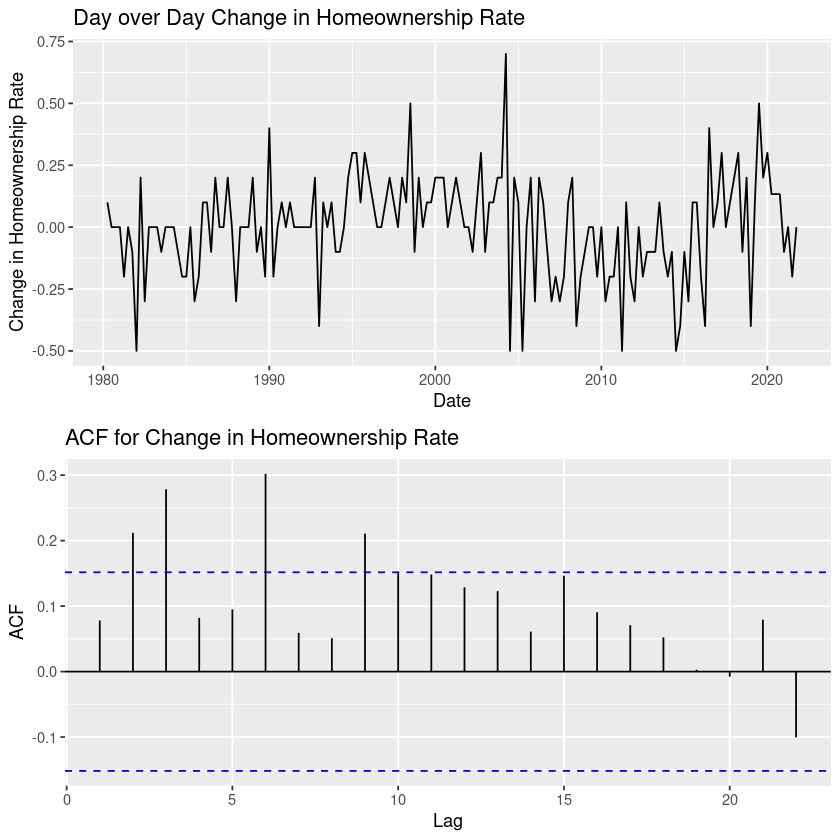

In [6]:
homeownership <- read_homeownership()
homeownership[tsoutliers(homeownership$Value)$index,]
cleaned_homeownership <- homeownership %>% mutate(Value = tsclean(Value))
homeownership_diff <- cleaned_homeownership %>% mutate(Value = c(NA, diff(Value))) %>% drop_na

p1 <- homeownership_diff %>% ggplot() +
    geom_line(aes(x = Date, y = Value)) +
    labs(y = "Change in Homeownership Rate", title = "Day over Day Change in Homeownership Rate")
p2 <- ggAcf(homeownership_diff$Value) + 
    labs(title = "ACF for Change in Homeownership Rate")
ggarrange(p1, p2, nrow = 2, ncol = 1)

# ARIMA Fit

In [7]:
test_split = 4
train <- head(homeownership_diff, -test_split)
test <- tail(homeownership_diff, test_split)

In [9]:
arima_comp <- find_best_arima(train$Value, 0:5, 0:2, 0:5)
head(arima_comp)

,p,d,q,AICC
,<int>,<int>,<int>,<dbl>
1,5,0,4,-74.22452
2,4,0,5,-74.21591
3,5,0,5,-71.75588
4,3,0,3,-71.75546
5,2,1,3,-70.07758
6,3,0,4,-69.52296



	Box-Ljung test

data:  residuals(model)
X-squared = 2.5973, df = 1, p-value = 0.107


	Box-Ljung test

data:  residuals(model)^2
X-squared = 9.936, df = 1, p-value = 0.001621



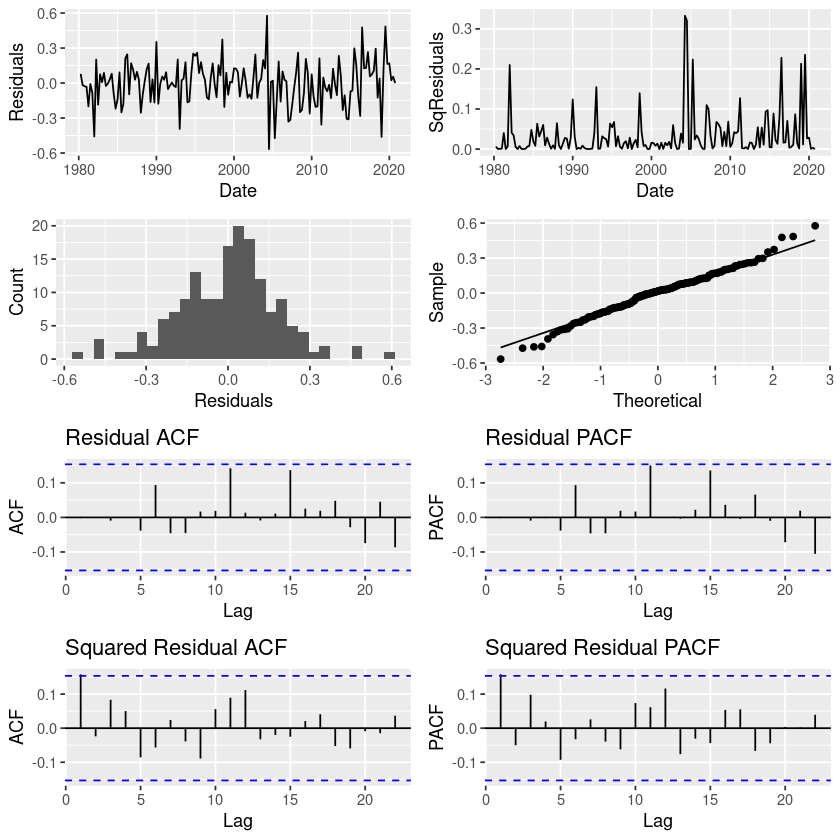

In [10]:
best_order <- arima_comp[1,1:3] %>% as.numeric
arima_model <- arima(train$Value, order = best_order, method = "ML")
residual_analysis(arima_model, train$Date)
box_tests(arima_model, best_order[1] + best_order[3])

# ARMA-GARCH Fit

In [11]:
ugarch_comp <- find_best_ugarch(homeownership_diff$Value, best_order[1], best_order[3], 0:5, 0:5, 0:2, 0:2, test_size = test_split)
head(ugarch_comp$Final)

,p,q,m,n,BIC
,<int>,<int>,<int>,<int>,<dbl>
1,5,3,0,1,-0.3914827
2,5,3,2,1,-0.3468127
3,5,3,2,0,-0.3285352
4,5,3,1,0,-0.2628873
5,5,3,0,0,-0.2133050
6,5,3,0,2,-0.1698879



	Box-Ljung test

data:  residuals(model)
X-squared = 16.46, df = 1, p-value = 4.97e-05


	Box-Ljung test

data:  residuals(model)^2
X-squared = 8.247, df = 1, p-value = 0.004082



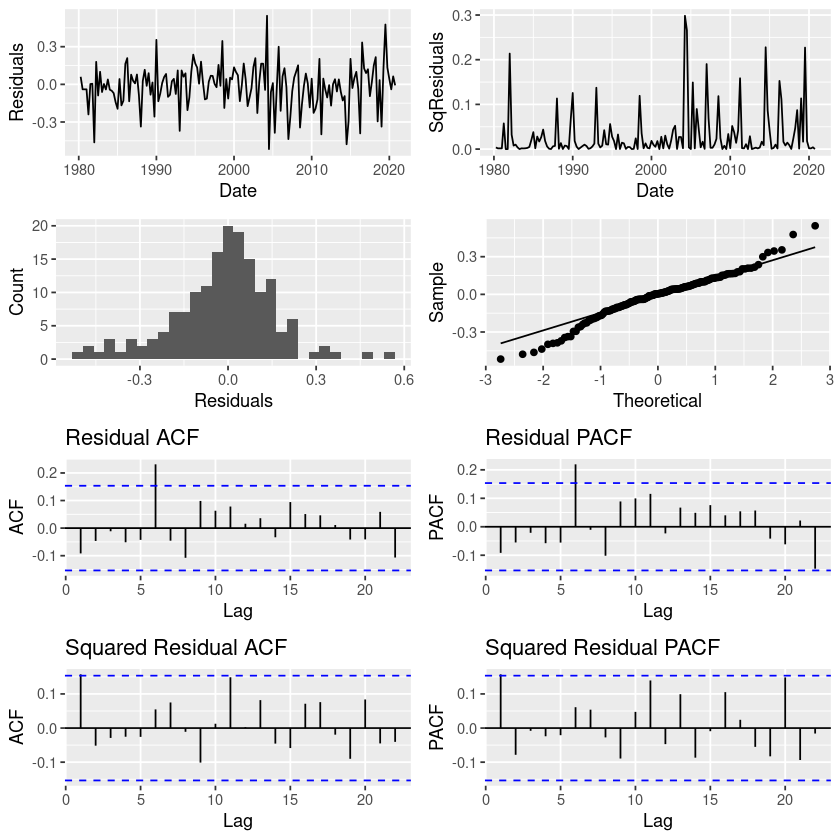

In [13]:
best_order <- as.numeric(ugarch_comp$Final[1,1:4])
spec <- ugarchspec(variance.model=list(garchOrder=c(best_order[3:4])),
                     mean.model=list(armaOrder=c(best_order[1:2]),
                                     include.mean=T), distribution.model="std")
ugarch_model <- ugarchfit(spec, homeownership_diff$Value, solver = 'hybrid', out.sample = test_split)
residual_analysis(ugarch_model, train$Date)
box_tests(ugarch_model, sum(best_order))

# Forecasting

## ARIMA

PM =  5.916148

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.1828552,0.2016768,0.1828552,-Inf,Inf


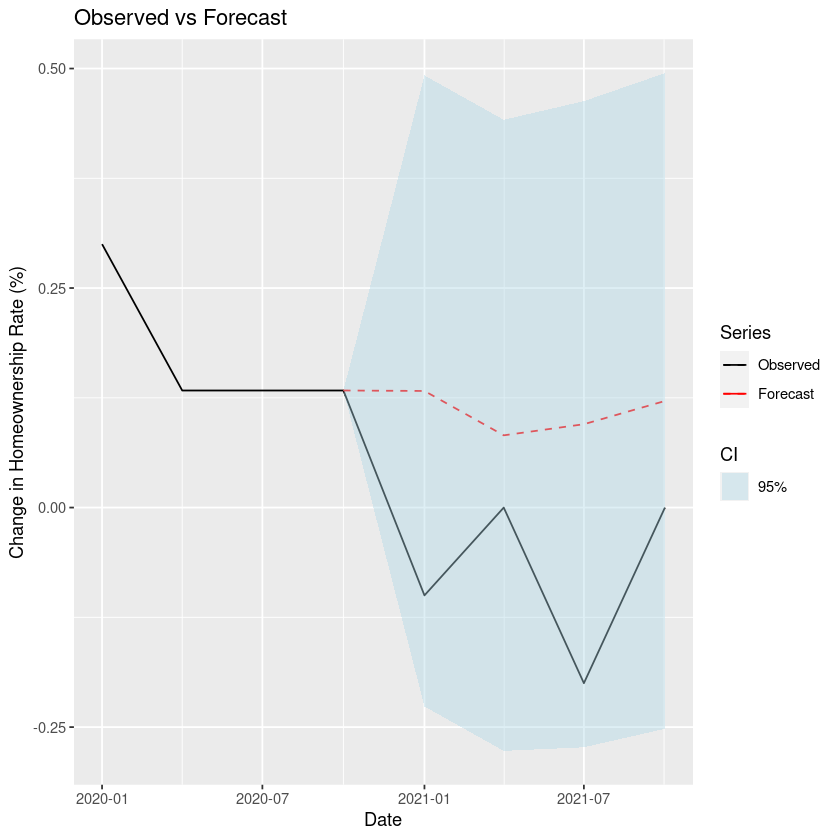

In [15]:
arima_fc <- forecast_arima(arima_model, homeownership_diff$Date, homeownership_diff$Value, test_split, 95,
                    y_lab = "Change in Homeownership Rate (%)")
arima_fc$plot
fc_data <- tail(arima_fc$data, test_split)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)

## ARMA-GARCH: Model 1

PM =  2.63955

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.07100973,0.1347104,0.1299426,NaN,Inf


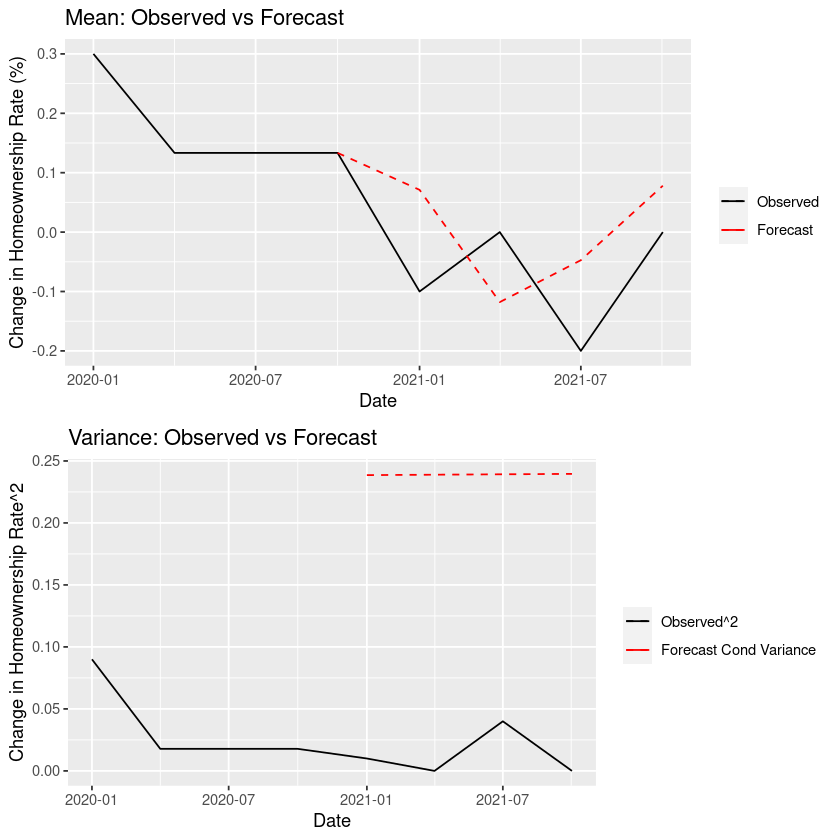

In [16]:
ugarch_fc <- forecast_ugarchroll(ugarch_model, homeownership_diff$Date, test$Value, test_split,
                          y_lab = c("Change in Homeownership Rate (%)", "Change in Homeownership Rate^2"))
ugarch_fc$plot
fc_data <- tail(ugarch_fc$data, test_split)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)

# Undifferenced Reconstruction

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.4723255,0.5149165,0.4723255,-0.7215717,0.7215717


,ME,RMSE,MAE,MPE,MAPE
Test set,-0.1785874,0.1969822,0.1785874,-0.2728079,0.2728079


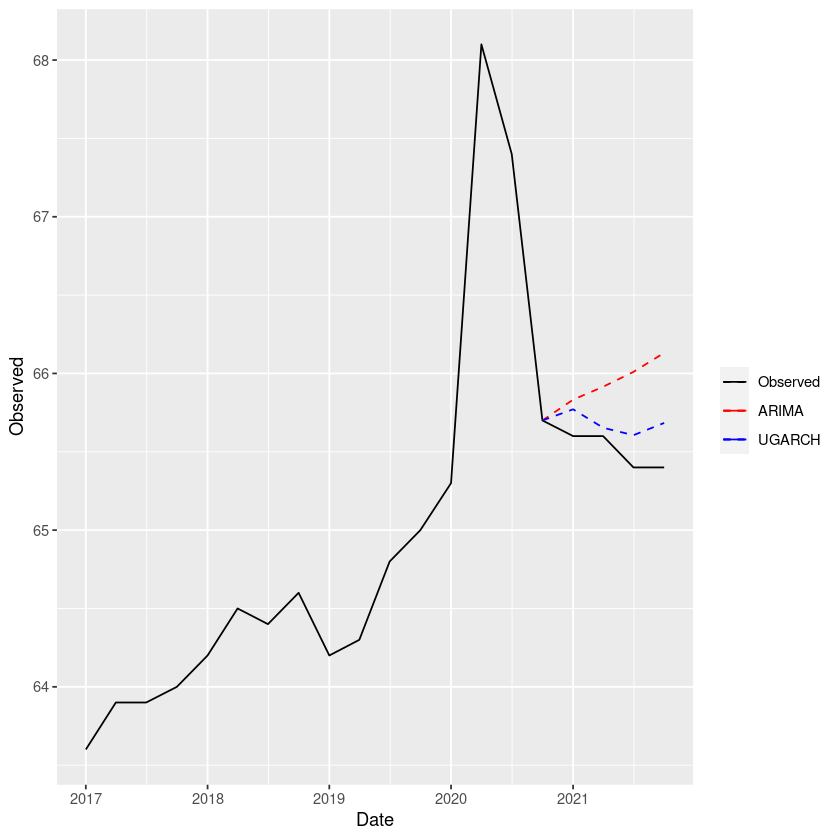

In [17]:
arima_recon <- diffinv(c(train$Value, tail(arima_fc$data$Forecast, test_split)),
                       xi = homeownership$Value[1])
ugarch_recon <- diffinv(c(train$Value, tail(ugarch_fc$data$Forecast, test_split)),
                        xi = homeownership$Value[1])
combined_recon <- data.frame(Date = homeownership$Date,
                            Observed = homeownership$Value,
                            ARIMA = arima_recon,
                            UGARCH = ugarch_recon)

combined_recon %>% tail(20) %>% ggplot() +
  geom_line(aes(x = Date, y = Observed, color = "Observed")) +
  geom_line(data = tail(combined_recon, test_split + 1), aes(x = Date, y = ARIMA, color = "ARIMA"), linetype = "dashed") +
  geom_line(data = tail(combined_recon, test_split + 1), aes(x = Date, y = UGARCH, color = "UGARCH"), linetype = "dashed") +
  scale_color_manual("", values = c("Observed" = "black", "ARIMA" = "red",
                                    "UGARCH" = "blue"))

fc_only <- tail(combined_recon, test_split)

accuracy(fc_only$ARIMA, x = fc_only$Observed)
accuracy(fc_only$UGARCH, x = fc_only$Observed)